In [1]:
!pip install -q gdown
!gdown --id 1ErivRe__3kjo9SlbmjSXEM7snEZ_M2zZ
!gdown --id 1ip5nmsRAfUrR-fzzQEDSyrngh9UM_ySM
!unzip -q Images.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ErivRe__3kjo9SlbmjSXEM7snEZ_M2zZ
From (redirected): https://drive.google.com/uc?id=1ErivRe__3kjo9SlbmjSXEM7snEZ_M2zZ&confirm=t&uuid=6a76f2d7-5333-4b85-8652-9aab1691b778
To: /content/Images.zip
100% 1.11G/1.11G [00:21<00:00, 52.0MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ip5nmsRAfUrR-fzzQEDSyrngh9UM_ySM
To: /content/captions.csv
100% 3.32M/3.32M [00:00<00:00, 172MB/s]


In [2]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00


Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import keras_tuner as kt
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

Managing File Paths

In [4]:
DATASET_PATH = 'Images'
CAPTION_PATH = 'captions.csv'
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODELS_DIR = os.path.join(OUTPUT_DIR, 'Models')
os.makedirs(MODELS_DIR, exist_ok=True)


Parse Captions

In [5]:
def load_image_captions(filepath):
    captions = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(',', 1)
            if len(parts) < 2:
                continue
            image_id, caption = parts
            image_id = image_id.strip().split('.')[0]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append("<start> " + caption.strip() + " <end>")
    return captions


Recreate captions

In [6]:
def recreate_captions(captions):
    for img_id in captions:
        captions[img_id] = [cap.lower() for cap in captions[img_id]]
    return captions

In [7]:
captions = load_image_captions(CAPTION_PATH)
captions = recreate_captions(captions)
print(f"Captions: {len(captions)} ")

Captions: 8092 


Spliting the data

In [8]:
def create_data_splits(captions):
    all_image_ids = list(captions.keys())
    np.random.seed(42)
    np.random.shuffle(all_image_ids)
    train_split = int(0.7 * len(all_image_ids))
    val_split = int(0.85 * len(all_image_ids))
    return all_image_ids[:train_split], all_image_ids[train_split:val_split], all_image_ids[val_split:]

train_ids, val_ids, test_ids = create_data_splits(captions)
print(f"Train: {len(train_ids)}, Validation: {len(val_ids)}, Test: {len(test_ids)}")


Train: 5664, Validation: 1214, Test: 1214


Vocabulary and Tokenizer Captions

In [9]:
def build_vocabulary(captions):
    all_captions = [caption for caption_list in captions.values() for caption in caption_list]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocabulary_size = len(tokenizer.word_index) + 1
    max_caption_length = max(len(c.split()) for c in all_captions)
    return tokenizer, vocabulary_size, max_caption_length

tokenizer, vocabulary_size, max_caption_length = build_vocabulary(captions)
print(f"Size of Vocabulary: {vocabulary_size}, Max length of captions: {max_caption_length}")


Size of Vocabulary: 8495, Max length of captions: 40


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization, ReLU
from tensorflow.keras import Sequential

def build_custom_cnn():
    model = Sequential([
        Input(shape=(299, 299, 3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),  # Replace Flatten with this for feature vector
    ])
    return model


Extract image features

In [11]:
feature_file_path = os.path.join(OUTPUT_DIR, "custom_image_features.pkl")
if os.path.exists(feature_file_path):
    with open(feature_file_path, 'rb') as file:
        features = pickle.load(file)
    print("Image features loaded from file.")
else:
    base_model = build_custom_cnn()

    def extract_image_features(image_dir, image_ids):
        features = {}
        for img_id in tqdm(image_ids):
            file_path = os.path.join(image_dir, img_id + ".jpg")
            if not os.path.exists(file_path): continue
            img = load_img(file_path, target_size=(299, 299))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)  # Still needed if you want normalized input
            feature = base_model.predict(img, verbose=0)
            features[img_id] = feature.flatten()
        return features

    features = extract_image_features(DATASET_PATH, list(set(train_ids + val_ids + test_ids)))

    # Save features
    with open(feature_file_path, "wb") as file:
        pickle.dump(features, file)
    print("Image features extracted and saved using custom CNN.")


100%|██████████| 8092/8092 [10:48<00:00, 12.49it/s]

Image features extracted and saved using custom CNN.


Sequences for Training

In [12]:
# Function to create vocabulary from all captions
def create_vocabulary(captions):
    all_captions = [caption for cap_list in captions.values() for caption in cap_list]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(c.split()) for c in all_captions)
    return tokenizer, vocab_size, max_length

# Generate tokenizer, vocab size, and max caption length
tokenizer, vocab_size, max_length = create_vocabulary(captions)
print(f"Size of Vocabulary :{vocab_size}, Max length of captions: {max_length}")

# Function to generate sequences for image captioning
def generate_sequences(tokenizer, max_length, captions, features, image_ids):
    image_inputs, sequence_inputs, next_words = [], [], []

    for img_id in image_ids:
        if img_id not in captions or img_id not in features:
            continue
        for caption in captions[img_id]:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                image_inputs.append(features[img_id])
                sequence_inputs.append(seq[:i])
                next_words.append(seq[i])

    padded_sequences = pad_sequences(sequence_inputs, maxlen=max_length, padding='post')
    return np.array(image_inputs), np.array(padded_sequences), np.array(next_words)

# Generate training and validation data
train_img, train_seq, train_out = generate_sequences(tokenizer, max_length, captions, features, train_ids)
val_img, val_seq, val_out = generate_sequences(tokenizer, max_length, captions, features, val_ids)

print(f"Train samples: {len(train_img)}")
print(f"Validation samples: {len(val_img)}")


Size of Vocabulary :8495, Max length of captions: 40
Train samples: 335100
Validation samples: 71484


Define hyperparameters and Model

In [13]:
def construct_model(hyper):
    feature_size = train_img.shape[1]

    embedding_dim = hyper.Choice('embedding_dim', [64, 128, 256])
    lstm_units = hyper.Choice('lstm_units', [128, 256, 512])
    dense_units = hyper.Choice('dense_units', [256, 512])
    dropout_rate = hyper.Float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = hyper.Choice('learning_rate', [1e-3, 1e-4, 1e-5])

    image_input = Input(shape=(feature_size,))
    x1 = Dropout(dropout_rate)(image_input)
    x2 = Dense(dense_units, activation='relu')(x1)

    caption_input = Input(shape=(max_length,))
    x3 = Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)
    x4 = Dropout(dropout_rate)(x3)
    x5 = LSTM(lstm_units)(x4)

    merged = add([x2, Dense(dense_units)(x5)])
    x6 = Dense(dense_units, activation='relu')(merged)
    output = Dense(vocab_size, activation='softmax')(x6)

    model = Model(inputs=[image_input, caption_input], outputs=output)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model


hyper parameter tuning

In [14]:
tuner = kt.RandomSearch(
    construct_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory=os.path.join(OUTPUT_DIR, 'caption_tuning'),
    project_name='cnn_lstm_tune'
)


In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
embedding_dim (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
lstm_units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
dense_units (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


In [16]:
tuner.search(
    [train_img, train_seq], train_out,
    validation_data=([val_img, val_seq], val_out),
    epochs=5,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)


Trial 2 Complete [00h 06m 35s]
val_accuracy: 0.3736080825328827

Best val_accuracy So Far: 0.3754546344280243
Total elapsed time: 00h 13m 09s


In [17]:
optimal_hyperparams = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", optimal_hyperparams.values)


Best hyperparameters: {'embedding_dim': 256, 'lstm_units': 256, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001}


Model with best parameter

In [18]:


# Build the model with the best hyperparameters
best_model = construct_model(optimal_hyperparams)
best_model.summary()

# Train the model with the best hyperparameters
best_model.fit(
    [train_img, train_seq], train_out,
    validation_data=([val_img, val_seq], val_out),
    epochs=10,  # You might want to increase the number of epochs
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3),
               ModelCheckpoint(os.path.join(MODELS_DIR, 'best_model.h5'),
                               save_best_only=True, save_weights_only=False)]
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 40, 256)   │  2,174,720 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 40, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 40)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8495)      │  2,183,215 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,080,623 (19.38 MB)

 Trainable params: 5,080,623 (19.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2657 - loss: 4.4538

5236/5236 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step - accuracy: 0.2657 - loss: 4.4537 - val_accuracy: 0.3420 - val_loss: 3.6376
Epoch 2/10
5232/5236 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3511 - loss: 3.3956

5236/5236 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.3511 - loss: 3.3956 - val_accuracy: 0.3603 - val_loss: 3.5045
Epoch 3/10
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3711 - loss: 3.1283

5236/5236 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - accuracy: 0.3711 - loss: 3.1283 - val_accuracy: 0.3694 - val_loss: 3.4907
Epoch 4/10
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 65s 12ms/step - accuracy: 0.3862 - loss: 2.9596 - val_accuracy: 0.3747 - val_loss: 3.5104
Epoch 5/10
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - accuracy: 0.3986 - loss: 2.8276 - val_accuracy: 0.3758 - val_loss: 3.5459
Epoch 6/10
5236/5236 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.4053 - loss: 2.7408 - val_accuracy: 0.3765 - val_loss: 3.5935


Plot loss and accuracy curves

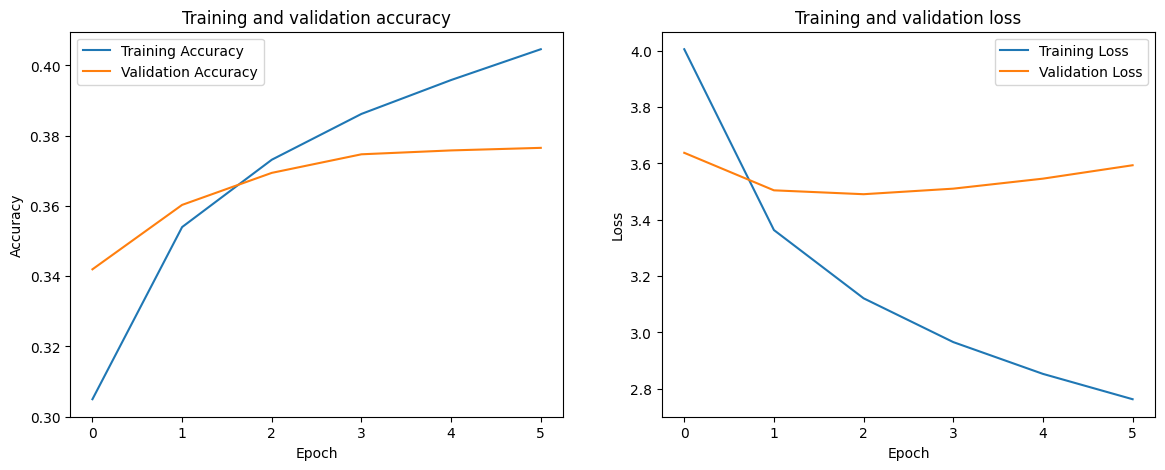

In [19]:

import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot training and validation accuracy per epoch
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    # Plot training and validation loss per epoch
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_curves(best_model.history)


In [20]:

print("Saving the final model...")
best_model.save(os.path.join(MODELS_DIR, 'final_model.keras'))
with open(os.path.join(OUTPUT_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
with open(os.path.join(OUTPUT_DIR, 'max_length.pkl'), 'wb') as f:
    pickle.dump(max_length, f)


Saving the final model...


Define a function for generating captions for new images

In [21]:

def generate_caption(model, image_path, tokenizer, max_length, features=None):
    # Extract features if not provided
    if features is None:
        img = load_img(image_path, target_size=(299, 299))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = base_model.predict(img, verbose=0)
        feature = feature.flatten()
    else:
        img_id = os.path.basename(image_path).split('.')[0]
        if img_id in features:
            feature = features[img_id]
        else:
            return "Image features not found"
    # Generate caption
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([np.array([feature]), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ''
        for w, idx in tokenizer.word_index.items():
            if idx == yhat:
                word = w
                break
        if word is None or word == '<end>':
            break
        in_text += ' ' + word
    # Remove <start>
    caption = in_text.replace('<start>', '').strip()
    return caption


Test the model on a few test images

In [24]:

def test_model(model, test_ids, n_samples=5):
    print("\nTesting the model on sample images:")
    np.random.shuffle(test_ids)
    for i, img_id in enumerate(test_ids[:n_samples]):
        if img_id not in features:
            continue
        img_path = os.path.join(DATASET_PATH, img_id + '.jpg')
        if not os.path.exists(img_path):
            continue
        # Generate caption
        caption = generate_caption(model, img_path, tokenizer, max_length, features)
        # Display original captions for comparison
        original_captions = captions.get(img_id, ["No caption available"])
        original_formatted = [cap.replace('<start>', '').replace('<end>', '').strip() for cap in original_captions]
        print(f"Image {i+1} (ID: {img_id}):")
        print(f"Generated: {caption}")
        print(f"Original: {original_formatted[0]}")
        print("-" * 50)

# Load the best model and test it
try:
    final_model = tf.keras.models.load_model(os.path.join(MODELS_DIR, 'final_model.keras'))
    print("Loaded saved model.")
    test_model(final_model, test_ids)
except Exception as e:
    print(f"No saved model found or error loading model: {e}")
    print("Using the last trained model.")
    test_model(best_model, test_ids)
print("Image captioning model training and testing complete!")


Loaded saved model.

Testing the model on sample images:
Image 1 (ID: 498444334_a680d318a1):
Generated: a man in a red shirt is standing in front of a building end of a large rock end end end end end end end end end end end of a bench end end end end end end end end
Original: a group of young men clowning around while enjoying a beverage .
--------------------------------------------------
Image 2 (ID: 2102724238_3cf921d7bb):
Generated: a man in a red shirt is standing in front of a crowd of people end end of a bench end end end end end end end of a bench end end end end end end end end end of
Original: "a woman in a knit cap and a man in a peacoat sit on a subway , laden with bags ."
--------------------------------------------------
Image 3 (ID: 3177799416_5bd0382370):
Generated: a man in a blue shirt is standing on a beach end of a snowy mountain end end end end end end end end end end end end end end end end end end end end end end end end
Original: a person snowboarding down a sno